In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import constants as ct

Unidades e casos

In [2]:
df_estab = pd.read_csv(ct.PATH_UNIDADES)
df_gripe = pd.read_csv(ct.PATH_GRIPE_MIN)

União

In [3]:
COL_CNES_gripe = 'CNES da unidade de saúde de internação'
COL_CNES_estab = 'CO_CNES'

qtd_cols = ['QT_EXIST','QT_SUS']

df_estab_qtd = df_estab.groupby(COL_CNES_estab)[qtd_cols].sum()

df_gripe_estab = pd.merge(df_gripe, df_estab_qtd, how='inner', left_on=COL_CNES_gripe, right_on=COL_CNES_estab)

## Data to datetime

In [4]:
data_cols = [x for x in df_gripe_estab.columns if 'Data' in x]

In [5]:
for data in data_cols:
    df_gripe_estab[data] = pd.to_datetime(df_gripe_estab[data], format="%d/%m/%Y")

## Tempo internado

In [6]:
COL_TEMPO_INTERNADO = "Tempo internado"
df_gripe_estab[COL_TEMPO_INTERNADO] = df_gripe_estab['Data da alta ou óbito']-df_gripe_estab['Data de internação']

In [7]:
df_gripe_estab[COL_TEMPO_INTERNADO] = df_gripe_estab[COL_TEMPO_INTERNADO].fillna(df_gripe_estab[COL_TEMPO_INTERNADO].mean())

## Número de internações

In [8]:
df_entrada_grp = df_gripe_estab.groupby(['Data de internação', COL_CNES_gripe]).apply(len)

In [9]:
df_entrada_grp = df_entrada_grp.reset_index()

Range de período de internação

In [10]:
df_gripe_estab['Data de internação'].max()

Timestamp('2020-05-15 00:00:00')

In [13]:
df_gripe_estab['Data de saída'] = df_gripe_estab['Data de internação'] + df_gripe_estab['Tempo internado']

In [70]:
data_min = df_entrada_grp['Data de internação'].min()
data_max = df_gripe_estab['Data de saída'].max()

In [71]:
data_min, ' ', data_max

(Timestamp('2019-12-31 00:00:00'), ' ', Timestamp('2020-05-22 00:00:00'))

In [72]:
datas_entrada = pd.date_range(data_min, data_max)

In [73]:
unidades = df_entrada_grp[COL_CNES_gripe].unique()

## Todas as Unidades ao longo de todos os dias

In [74]:
import itertools

In [75]:
df_all_entrada = pd.DataFrame(list(itertools.product(datas_entrada, unidades)), columns=['Data','Unidade'])

In [76]:
len(df_all_entrada)

16848

## Data de Entrada

In [77]:
df_entrada_full = pd.merge(
    df_all_entrada, df_entrada_grp, 
    how='left',left_on=['Data','Unidade'],right_on=['Data de internação',COL_CNES_gripe])

In [78]:
df_entrada_full = df_entrada_full.rename({0:'entradas'},axis=1)

In [79]:
df_entrada_full['entradas'] = df_entrada_full['entradas'].fillna(0)

In [80]:
df_entrada_full = df_entrada_full[['Data','Unidade','entradas']]

## Data de saída

In [86]:
df_gripe_estab['Data de saída'] = df_gripe_estab['Data de internação'] + df_gripe_estab['Tempo internado']

In [87]:
df_saida_grp = df_gripe_estab.groupby(['Data de saída', 'CNES da unidade de saúde de internação']).apply(len).reset_index()

In [88]:
df_saida_grp['Data de saída'] = df_saida_grp['Data de saída'].dt.floor('d')

In [90]:
df_saida_grp.shape

(3402, 3)

In [93]:
df_full = pd.merge(
    df_entrada_full, 
    df_saida_grp,
    how='left',
    left_on=['Data','Unidade'], 
    right_on=['Data de saída',COL_CNES_gripe])

In [94]:
df_full.shape

(17496, 6)

In [27]:
df_full = df_full.rename({0:'saidas'},axis=1)

In [28]:
df_full['saidas'] = df_full['saidas'].fillna(0)

In [29]:
df_full = df_full[['Data','Unidade','entradas','saidas']].copy()

In [30]:
df_full['entradas_sum'] = df_full.groupby('Unidade')[['entradas']].cumsum()
df_full['saidas_sum'] = df_full.groupby('Unidade')[['saidas']].cumsum()

In [31]:
df_full['ocupacao'] = df_full['entradas_sum'] - df_full['saidas_sum']

In [32]:
df_full['ocupacao'].min()

0.0

In [33]:
df_full['ocupacao'].max()

370.0

In [34]:
df_full.to_csv('../../BASE_DE_DADOS_CNES_202003/dataset/ocupacao.csv',index=False)

In [35]:
df_leitos = df_gripe_estab[[COL_CNES_gripe,'QT_EXIST','QT_SUS']]

In [36]:
df_leitos.shape

(7147, 3)

In [37]:
df_full.shape

(16677, 7)

In [38]:
df_occ = pd.merge(df_full, df_leitos, how='inner',left_on=['Unidade'], right_on=[COL_CNES_gripe])

In [39]:
df_occ = df_occ.drop_duplicates()

In [40]:
df_occ_min = df_occ[['Data','Unidade','entradas','saidas','ocupacao','QT_EXIST','QT_SUS']].copy()

In [41]:
df_occ_min['disponiveis'] = df_occ_min['QT_EXIST'] - df_occ_min['ocupacao']

In [42]:
df_occ_min['Unidade'].value_counts()

3034984    171
5717256    170
2295407    165
3005992    164
2298120    160
          ... 
2758091    137
6159397    137
3012964    137
3185095    137
2270668    137
Name: Unidade, Length: 117, dtype: int64

In [43]:
df_occ_min.shape

(16677, 8)

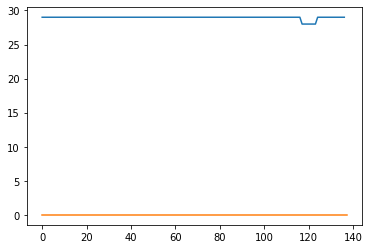

In [91]:
plot_data = df_occ_min[df_occ_min['Unidade']==3185095].reset_index()['disponiveis']
plt.plot(plot_data)
plt.plot([0,len(plot_data)],[0,0])

In [92]:
df_occ_min.to_csv("../../BASE_DE_DADOS_CNES_202003/dataset/ocupacao.csv", index=False)